In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU:0

from numba import cuda
cuda.select_device(0) # rm GPU from memory tf/keras
cuda.close()

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import set_config

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score, confusion_matrix

from performance import plot_roc, plot_learning_curves
from lcfunctions import load_lasair_lc, lasair_clean
from raw_processing import label_schemes

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight




### Generate dataset

In [3]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None
                     
dataset = pd.read_csv('../processed_data/AAVSOCVsZTFxmatch_21032023_BTS_manual_labelled.csv')
dataset = label_schemes(dataset)

dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
dataset.columns

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


Index(['oid_ztf', 'oid_aavso', 'type_aavso', 'ra', 'dec', 'Eclipsing',
       'CV_Types', 'CV_subtypes', 'CV_subsubtypes', 'eclipse_clear',
       'manual_label', 'Clarity', 'labels_1', 'labels_2', 'labels_3',
       'labels_4'],
      dtype='object')

### Dictionary of light curve information

In [4]:
# Create a dictionary of dictionary, where each sub-dictionary contains the light curve data for a given object

def lightcurve_dictionary(dataset, lc_folder = '../lightcurves_dataset/lasair_2023_03_25'):

    lightcurves = {}
    for obj in dataset['oid_ztf']:
        print(obj)
        # Load and process lasair light curve, the split into g and r bands
        lc_test = load_lasair_lc(oid=obj, path=lc_folder)
        lc_appmag_test = lasair_clean(lc_test, limit=25, magerrlim=1)
        df_lc = lc_appmag_test.copy()
        df_lc_g = df_lc[df_lc['fid'] == 1].reset_index(drop=True)
        df_lc_r = df_lc[df_lc['fid'] == 2].reset_index(drop=True)

        lightcurves[obj] = {'g_mag': df_lc_g['dc_mag'].values, 
                            'r_mag': df_lc_r['dc_mag'].values,
                            'g_jd': df_lc_g['jd'].values,
                            'r_jd': df_lc_r['jd'].values
                            }
    
    return lightcurves
    

lightcurves = lightcurve_dictionary(dataset)

ZTF18abryuah
ZTF18abtrvgp
ZTF17aaaehby
ZTF18abgjgiq
ZTF18abumlux
ZTF18absgnqy
ZTF18aaxdlbl
ZTF18absgzlu
ZTF18acegnyn
ZTF18aaadtna
ZTF18acywwfg
ZTF17aabxrtj
ZTF18aagqeuv
ZTF18aahmxsl
ZTF17aaarxou
ZTF17aaairkd
ZTF19aabiema
ZTF18acnnsmq
ZTF18abcrbmk
ZTF18admxenl
ZTF18abwiccd
ZTF18abwpsyj
ZTF18aaylcic
ZTF18aagrcve
ZTF20abragvw
ZTF19abhpnxh
ZTF18adlhiaq
ZTF18aazucqe
ZTF18abnbluc
ZTF18aajqtnw
ZTF18aapovzp
ZTF18aainbrb
ZTF18aauxwft
ZTF18aaxcqso
ZTF19abtsrif
ZTF18abuhqfi
ZTF19aakuyyr
ZTF17aacbuuj
ZTF17aadnfyi
ZTF20abbndvn
ZTF18aaldiqd
ZTF18aaojabr
ZTF18aabpzjg
ZTF18acviwua
ZTF18aalurkz
ZTF18acurptp
ZTF18acrxpcz
ZTF18aaqphee
ZTF17aaaizfe
ZTF18aaarims
ZTF17aaajlfw
ZTF17aabtvrf
ZTF19aakvlvn
ZTF19aapzvoj
ZTF18aaadlpa
ZTF17aaairls
ZTF18aaowqsq
ZTF18aalgarl
ZTF18aapobha
ZTF17aaagrxo
ZTF17aaaufmh
ZTF17aabskxk
ZTF18actbrbg
ZTF18acqxpha
ZTF19aaclwhr
ZTF18abttrrr
ZTF18abcoxgp
ZTF18abadsmu
ZTF18abuescl
ZTF18admesgz
ZTF18abccodq
ZTF18abcqzxh
ZTF18abotfmi
ZTF17aaabbhn
ZTF20acowhlb
ZTF17aacpvmc
ZTF19aayjhzx

### Functions for obtaining different input representations

In [88]:
from scipy.signal import find_peaks

def getdiffs(array):
    if len(array):
        diffs = np.diff(array)
        return diffs
    else:
        return np.array([])

def backfilled_magnitudes(lightcurves, n_pts=1000, backfill_value=np.nan):
    X_gmag = np.empty((0, n_pts))
    X_rmag = np.empty((0, n_pts))
    X_gjd = np.empty((0, n_pts))
    X_rjd = np.empty((0, n_pts))

    for obj in lightcurves.keys():
        for key in ['g_mag', 'r_mag', 'g_jd', 'r_jd']:
            lc = lightcurves[obj][key]

            if key == 'g_jd' or key == 'r_jd':
                try:
                    lc = (lc - lc[0])
                except:
                    lc = []

            if len(lc) < n_pts:
                lc = np.pad(lc, (n_pts-len(lc), 0), 'constant', constant_values=(backfill_value, backfill_value))
            elif len(lc) >= n_pts:
                lc = lc[-n_pts:]
            
            if key == 'g_mag':
                X_gmag = np.vstack((X_gmag, lc))
            elif key == 'r_mag':
                X_rmag = np.vstack((X_rmag, lc))
            elif key == 'g_jd':
                X_gjd = np.vstack((X_gjd, lc))
            elif key == 'r_jd':
                X_rjd = np.vstack((X_rjd, lc))
            
    return X_gmag, X_rmag, X_gjd, X_rjd


def dmdt(lightcurves, n_pts=500, backfill_value=np.nan):

    X_gdm = np.empty((0, n_pts))
    X_gdt = np.empty((0, n_pts))
    X_rdm = np.empty((0, n_pts))
    X_rdt = np.empty((0, n_pts))

    for obj in lightcurves.keys():
        for key in ['g_mag', 'r_mag', 'g_jd', 'r_jd']:
            lc = lightcurves[obj][key]

            if len(lc) > 0:
                diff = np.diff(lc)
                diff = np.insert(diff, 0, 0)
            elif len(lc) == 0:
                diff = np.array([])
            
            if len(diff) < n_pts:
                diff = np.pad(diff, (n_pts-len(diff), 0), 'constant', constant_values=(backfill_value, backfill_value))
                
            elif len(diff) >= n_pts:
                diff = diff[-n_pts:]
            
            if key == 'g_mag':
                X_gdm = np.vstack((X_gdm, diff))
            elif key == 'r_mag':
                X_rdm = np.vstack((X_rdm, diff))
            elif key == 'g_jd':
                X_gdt = np.vstack((X_gdt, diff))
            elif key == 'r_jd':
                X_rdt = np.vstack((X_rdt, diff))

    return X_gdm, X_rdm, X_gdt, X_rdt


def interpolated_lcs(lightcurves, interp_pts=1000, true_cadence=True, backfill_value=0, cadence=1):
        X_ginterp = np.empty((0, interp_pts))
        X_rinterp = np.empty((0, interp_pts))

    
        for obj in list(lightcurves.keys()):

            for magkey, timekey in zip(['g_mag', 'r_mag'], ['g_jd', 'r_jd']):
                mag = lightcurves[obj][magkey]
                time = lightcurves[obj][timekey]

                # Convert jd to days since first observation
                try:
                    time = (time - time[0])
                except:
                    time = []

                 # Interpolate the light curve to 1 day cadence or a set number of points
                try:
                    if true_cadence==True:
                        lc_interp = np.interp(np.arange(0, time[-1], cadence), time, mag)
                    elif true_cadence==False:
                        lc_interp = np.interp(np.arange(0, time[-1], time[-1]/interp_pts), time, mag)
                except:
                    lc_interp = np.array([])
                
                # Pad the light curve with zeros if it is shorter than the desired length, or trim it if it is longer
                if len(lc_interp) < interp_pts:
                    lc_interp = np.pad(lc_interp, (interp_pts-len(lc_interp), 0), 'constant', constant_values=(backfill_value, backfill_value))
                elif len(lc_interp) >= interp_pts:
                    lc_interp = lc_interp[-interp_pts:]
                
                # Append the interpolated light curve to the appropriate array
                if magkey == 'g_mag':
                    X_ginterp = np.vstack((X_ginterp, lc_interp))
                elif magkey == 'r_mag':
                    X_rinterp = np.vstack((X_rinterp, lc_interp))

        return X_ginterp, X_rinterp


def gminusr(lightcurves, interp_pts=500, true_cadence=True, backfill_value=0, cadence=1):

    clr = np.empty((0, interp_pts))

    for obj in list(lightcurves.keys()):
        # print(obj)
        # df_g = pd.DataFrame(lightcurves[obj]['g_mag', 'g_jd'].copy())
        gmag = lightcurves[obj]['g_mag'].copy()
        gjd = lightcurves[obj]['g_jd'].copy()
        rmag = lightcurves[obj]['r_mag'].copy()
        rjd = lightcurves[obj]['r_jd'].copy()

        gjd = gjd.astype(int)
        rjd = rjd.astype(int)

        # Drop the duplicate jd and corresponding mag.
        g_jd_unique0 = np.unique(gjd, return_index=True)    # The unique function also returns the indices of unique values
        g_jd_unique = g_jd_unique0[0]                       # The unique jd values
        g_jd_unique_idx = g_jd_unique0[1]                   # The indices of the unique jd values can be used as a mask
        gmag_unique = gmag[g_jd_unique_idx]                 # The unique mag values

        r_jd_unique0 = np.unique(rjd, return_index=True)
        r_jd_unique = r_jd_unique0[0]
        r_jd_unique_idx = r_jd_unique0[1]
        rmag_unique = rmag[r_jd_unique_idx]

        # Get a boolean array of whether each g_jd_unique is in r_jd_unique. Use it as a mask to get gmag and rmag
        # values that were taken at the same time.
        gmask = np.in1d(g_jd_unique, r_jd_unique)
        gjd_inr = g_jd_unique[gmask]    
        # print(gjd_inr.shape)  
        gmag_inr = gmag_unique[gmask]  
        # print(gmag_inr.shape)        


        # Get a boolean array of whether each r_jd is in g_jd
        rmask = np.in1d(r_jd_unique, g_jd_unique)
        rjd_ing = r_jd_unique[rmask]
        # print(rjd_ing.shape)
        rmag_ing = rmag_unique[rmask]
        # print(rmag_ing.shape)

        # Convert jd to days since first observation
        try:
            time = (gjd_inr - gjd_inr[0])
        except:
            time = []
        
        clr_source = gmag_inr - rmag_ing

        # Interpolate the light curve to 1 day cadence or a set number of points
        try:
            if true_cadence==True:
                clr_interp = np.interp(np.arange(0, time[-1], cadence), time, clr_source)
            elif true_cadence==False:
                clr_interp = np.interp(np.arange(0, time[-1], time[-1]/interp_pts), time, clr_source)
        except:
            clr_interp = np.array([])
        
        # Pad the light curve with zeros if it is shorter than the desired length, or trim it if it is longer
        if len(clr_interp) < interp_pts:
            clr_interp = np.pad(clr_interp, (interp_pts-len(clr_interp), 0), 'constant', constant_values=(backfill_value, backfill_value))
        elif len(clr_interp) >= interp_pts:
            clr_interp = clr_interp[-interp_pts:]
        
        clr_interp = clr_interp.reshape(1, clr_interp.shape[0])
        # print(clr_source.shape)
        clr = np.vstack((clr, clr_interp))

    return clr, clr_source, time

def dmdt_hist(lightcurves, bins, limit, dm=False, usepeaks=False):

    g_all = np.array([])
    r_all = np.array([])
    g_hist_all = np.empty((0, bins))
    r_hist_all = np.empty((0, bins))

    rand = np.random.randint(0, len(lightcurves))
    for obj in list(lightcurves.keys()):#[rand:rand+1]:
        lc = lightcurves[obj]
        lc_g = lc['g_mag']
        lc_r = lc['r_mag']
        lc_g_jd = lc['g_jd']
        lc_r_jd = lc['r_jd']

        if usepeaks == True:
            # Find the peaks and the troughs of lc_g and lc_r
            g_peaks, _ = find_peaks(-lc_g, prominence=(None,None))
            g_troughs, _ = find_peaks(lc_g, prominence=(None,None))
            r_peaks, _ = find_peaks(-lc_r, prominence=(None,None))
            r_troughs, _ = find_peaks(lc_r, prominence=(None,None))

            lc_g = lc_g[np.sort(np.concatenate((g_peaks, g_troughs)))]
            lc_r = lc_r[np.sort(np.concatenate((r_peaks, r_troughs)))]
            lc_g_jd = lc_g_jd[np.sort(np.concatenate((g_peaks, g_troughs)))]
            lc_r_jd = lc_r_jd[np.sort(np.concatenate((r_peaks, r_troughs)))]
        

        # Get the dm and dt arrays
        g_dm = getdiffs(lc_g)
        r_dm = getdiffs(lc_r)
        g_dt = getdiffs(lc_g_jd)
        r_dt = getdiffs(lc_r_jd)

        if dm == True:
            # Just use the dms
            g_processed = g_dm
            r_processed = r_dm
        else:
            # Get the dmdt arrays
            g_dmdt = g_dm / g_dt
            g_processed = np.nan_to_num(g_dmdt, nan=0)
            r_dmdt = r_dm / r_dt
            r_processed = np.nan_to_num(r_dmdt, nan=0)

        # Add the g and r processed arrays to the all arrays
        g_all = np.append(g_all, g_processed, axis=0)
        r_all = np.append(r_all, r_processed, axis=0)

        # Get the histograms. First clip the arrays to the limit.
        g_processed[g_processed > limit] = limit
        g_processed[g_processed < -limit] = -limit
        r_processed[r_processed > limit] = limit
        r_processed[r_processed < -limit] = -limit

        g_hist, g_bins = np.histogram(g_processed, bins=np.linspace(-limit, limit, bins+1))
        r_hist, r_bins = np.histogram(r_processed, bins=np.linspace(-limit, limit, bins+1))

        # print(g_hist)

        # Add the histogram to the array
        g_hist_all = np.vstack((g_hist_all, g_hist))
        r_hist_all = np.vstack((r_hist_all, r_hist))

        # # plot the peaks and troughs and indicate them
        # plt.figure(figsize=(20, 5))
        # plt.plot(lc_g_jd, lc_g, '.')
        # plt.plot(lc_g_jd[g_peaks], lc_g[g_peaks], "x")
        # plt.plot(lc_g_jd[g_troughs], lc_g[g_troughs], "x")
        # plt.gca().invert_yaxis()
        # plt.show()

        # plt.figure(figsize=(20, 5))
        # plt.plot(lc_g_peaksandtroughs_jd, lc_g_peaksandtroughs, '.')
        # plt.gca().invert_yaxis()
        # plt.show()

        # print(np.diff(lc_g_peaksandtroughs))

    return g_hist_all, r_hist_all, g_all, r_all

def multi_channel(array_list):
    reshaped_arrays = []
    for array in array_list:
        reshaped_arrays.append(np.reshape(array, (array.shape[0], array.shape[1], 1)))

    new_arrray = np.concatenate(reshaped_arrays, axis=2)
    return new_arrray



### Obtain representation and reshape

In [89]:
# Get the representation.
# X_g, X_r, X_gjd, X_rjd = backfilled_magnitudes(lightcurves=lightcurves, n_pts=1000, backfill_value=0.0)
# X_g_hist, X_r_hist, a, b = dmdt_hist(lightcurves, bins=100, limit=10, dm=True, usepeaks=True)
X_g_int, X_r_int = interpolated_lcs(lightcurves, interp_pts=1000, true_cadence=True, backfill_value=0, cadence=1)
X_clr = gminusr(lightcurves, interp_pts=1000, true_cadence=True, backfill_value=0.0, cadence=1)[0]
# X_g_dmdthist = dmdt_hist(lightcurves, bins=100, limit=10, dm=False, usepeaks=True)[0]
# X_r_dmdthist = dmdt_hist(lightcurves, bins=100, limit=10, dm=False, usepeaks=True)[1]

# show = np.random.randint(0, len(X_g))
# plt.plot(X_g_int[show], '.')
# plt.gca().invert_yaxis()

# X_gr = multi_channel([X_g, X_r])
# X_gr_hist = multi_channel([X_g_hist, X_r_hist])
# Reshape the arrays.
# X_g = X_g.reshape(X_g.shape[0], X_g.shape[1], -1)


In [90]:
X_variant = X_g_int.reshape(X_g_int.shape[0], X_g_int.shape[1], -1)

# X_variant = multi_channel([X_g_dmhist.reshape(X_g_dmhist.shape[0], X_g_dmhist.shape[1], -1),
#                            X_r_dmhist.reshape(X_r_dmhist.shape[0], X_r_dmhist.shape[1], -1)])
X_multihead_1 = X_g_int.reshape(X_g_int.shape[0], X_g_int.shape[1], -1)
X_multihead_2 = X_r_int.reshape(X_r_int.shape[0], X_r_int.shape[1], -1)
X_multihead_3 = X_clr.reshape(X_clr.shape[0], X_clr.shape[1], -1)

print(X_variant.shape, X_multihead_1.shape, X_multihead_2.shape)

(1439, 1000, 1) (1439, 1000, 1) (1439, 1000, 1)


### Display representation

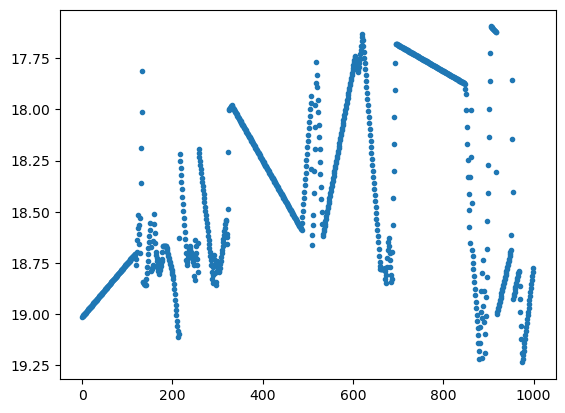

In [102]:
show = np.random.randint(0, len(X_variant))
plt.plot(X_variant[show], '.')
plt.gca().invert_yaxis()

### Obtain training and test sets

In [103]:
multihead = True
random_state = 10

# Get the labels as names
y_names = dataset[label_scheme].to_numpy()
# Encode the labels
enc = LabelEncoder().fit(y_names)
y_num = enc.transform(y_names)
# One hot encode the labels
y = to_categorical(y_num)

if multihead == True:

    # Train, test, split for multi-input model.
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_multihead_1, y, test_size=0.3, random_state=random_state)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_multihead_2, y, test_size=0.3, random_state=random_state)
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X_multihead_3, y, test_size=0.3, random_state=random_state)

    # Train, validation, split for multi-input model.
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.20, random_state=random_state)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.20, random_state=random_state)
    X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.20, random_state=random_state)

    # Single y_train, y_val, y_test for multi-input model.
    y_train = y_train1
    y_val = y_val1
    y_test = y_test1

    # # Normalise the data.
    mean1 = np.mean(X_train1)
    std1 = np.std(X_train1)
    X_train1 = (X_train1 - mean1) / std1
    X_val1 = (X_val1 - mean1) / std1
    X_test1 = (X_test1 - mean1) / std1

    mean2 = np.mean(X_train2)
    std2 = np.std(X_train2)
    X_train2 = (X_train2 - mean2) / std2
    X_val2 = (X_val2 - mean2) / std2
    X_test2 = (X_test2 - mean2) / std2

    mean3 = np.mean(X_train3)
    std3 = np.std(X_train3)
    X_train3 = (X_train3 - mean3) / std3
    X_val3 = (X_val3 - mean3) / std3
    X_test3 = (X_test3 - mean3) / std3

    print(f'X_train1, X_val1, X_test1 shapes: {X_train1.shape} {X_val1.shape} {X_test1.shape}')
    print(f'X_train2, X_val2, X_test2 shapes: {X_train2.shape} {X_val2.shape}, {X_test2.shape}')
    print(f'X_train3, X_val3, X_test3 shapes: {X_train3.shape} {X_val3.shape}, {X_test3.shape}')

elif multihead == False:
    # Train, validation, split for single-input model.
    X_train, X_test, y_train, y_test = train_test_split(X_variant, y, test_size=0.3, stratify=y, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=random_state)

    # Normalise the data.
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    print(f'X_train, X_val, X_test shapes: {X_train.shape} {X_val.shape} {X_test.shape}')


# Get the labels for each set as numbers.
y_train_labels = np.argmax(y_train, axis=1)

# Get the class weights for the training data.
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(zip(np.unique(y_train_labels), class_weights))


# Use over/undersampling to balance the training data.
us = np.unique(np.argmax(y_train, axis=1), return_counts=True)[1][1]
print(f'Undersample: {us}')
os = us
# Undersample the training data
class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:us}
# Oversample the training data
class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:os,
                enc.transform(['dwarf_nova_Z_Cam'])[0]:os,
                enc.transform(['dwarf_nova_U_Gem'])[0]:os,
                enc.transform(['nova_like_VY_Scl'])[0]:os,
                enc.transform(['polar'])[0]:os,
                enc.transform(['nova_like'])[0]:os,
                enc.transform(['nova'])[0]:os,
                enc.transform(['int_polar'])[0]:os,
                enc.transform(['AMCVn'])[0]:os
                }

undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=random_state)
oversample = RandomOverSampler(sampling_strategy=class_dist_os, random_state=random_state)

if multihead == True:
    X_train1_us, y_train1_us = undersample.fit_resample(X_train1.reshape(-1, X_train1.shape[1]*X_train1.shape[2]), y_train)
    X_train1_os, y_train1_os = oversample.fit_resample(X_train1_us, y_train1_us)
    X_train1_os = X_train1_os.reshape(-1, X_train1.shape[1], X_train1.shape[2])

    X_train2_us, y_train2_us = undersample.fit_resample(X_train2.reshape(-1, X_train2.shape[1]*X_train2.shape[2]), y_train)
    X_train2_os, y_train2_os = oversample.fit_resample(X_train2_us, y_train2_us)
    X_train2_os = X_train2_os.reshape(-1, X_train2.shape[1], X_train2.shape[2])

    X_train3_us, y_train3_us = undersample.fit_resample(X_train3.reshape(-1, X_train3.shape[1]*X_train3.shape[2]), y_train)
    X_train3_os, y_train3_os = oversample.fit_resample(X_train3_us, y_train3_us)
    X_train3_os = X_train3_os.reshape(-1, X_train3.shape[1], X_train3.shape[2])

    print(f'X_train1_os, y_train1_os shapes: {X_train1_os.shape} {y_train1_os.shape}')
    print(f'X_train2_os, y_train2_os shapes: {X_train2_os.shape} {y_train2_os.shape}')

elif multihead == False:
    X_train_us, y_train_us = undersample.fit_resample(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train)
    X_train_os, y_train_os = oversample.fit_resample(X_train_us, y_train_us)
    X_train_os = X_train_os.reshape(-1, X_train.shape[1], X_train.shape[2])

    print(f'X_train_os, y_train_os shapes: {X_train_os.shape} {y_train_os.shape}')





X_train1, X_val1, X_test1 shapes: (805, 1000, 1) (202, 1000, 1) (432, 1000, 1)
X_train2, X_val2, X_test2 shapes: (805, 1000, 1) (202, 1000, 1), (432, 1000, 1)
X_train3, X_val3, X_test3 shapes: (805, 1000, 1) (202, 1000, 1), (432, 1000, 1)
Undersample: 343
X_train1_os, y_train1_os shapes: (3087, 1000, 1) (3087, 9)
X_train2_os, y_train2_os shapes: (3087, 1000, 1) (3087, 9)


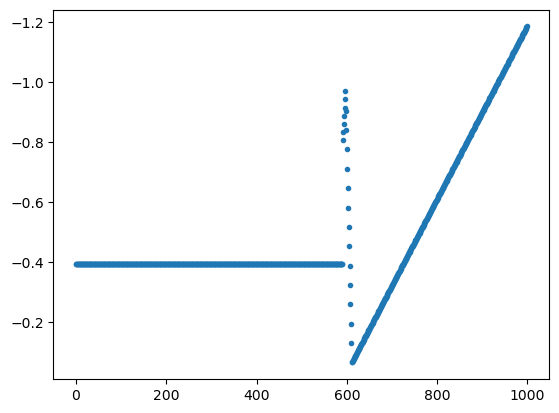

In [104]:
show = np.random.randint(0, len(X_train3_os))
plt.plot(X_train3_os[show], '.')
plt.gca().invert_yaxis()

### Build model function

In [105]:
def get_model(X_train, learning_rate=0.001, ks=10, l2=0.01):

    filters = 128

    # inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]), name="input")
    # x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_1', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(inputs)
    # x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_1')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_2', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_2')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_3', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_3')(x)
    # x = layers.Conv1D(filters=32, kernel_size=ks, activation="ReLU", padding='same', name='Conv1D_4')(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_4')(x)
    # x = layers.Conv1D(filters=64, kernel_size=ks, activation="ReLU", padding='valid', name='Conv1D_5')(x)
    # x = layers.MaxPooling1D(pool_size=2, name='MaxPool_5')(x)
    x = layers.GlobalMaxPooling1D(name='GlobalMaxPool')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Flatten(name='Flatten')(x)
    # x = layers.Dense(filters, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.05), name='Dense1')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(filters, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.05), name='Dense2')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(filters, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.05), name='Dense3')(x)
    outputs = layers.Dense(9, activation="softmax", name='Output')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    return model


def get_multiheadmodel(X_train_list, learning_rate=0.001, l2=0.01, ks=10):

    filters = 128

    input1 = keras.Input(shape=(X_train_list[0].shape[1], X_train_list[0].shape[2]), name="input1")
    input2 = keras.Input(shape=(X_train_list[1].shape[1], X_train_list[1].shape[2]), name="input2")
    input3 = keras.Input(shape=(X_train_list[2].shape[1], X_train_list[2].shape[2]), name="input3")

    x1 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='i1Conv1', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(input1)
    x1 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='i1Conv12', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x1)
    x1 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', name='i1Conv13', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x1)
    x1 = layers.GlobalMaxPooling1D(name='GlobalMaxPool')(x1)
    x1 = layers.Flatten()(x1)

    x2 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(input2)
    x2 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x2)
    x2 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x2)
    x2 = layers.GlobalMaxPooling1D(name='GlobalMaxPool2')(x2)
    x2 = layers.Flatten()(x2)

    x3 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(input3)
    x3 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x3)
    x3 = layers.Conv1D(filters=filters, kernel_size=ks, activation="ReLU", padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(x3)
    x3 = layers.GlobalMaxPooling1D(name='GlobalMaxPool3')(x3)
    x3 = layers.Flatten()(x3)

    x = layers.Concatenate()([x1, 
                              x2, 
                              x3
                              ])

    # x = layers.Dense(100, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0))(x)
    # x = layers.Dense(100, activation="ReLU", kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=0.0))(x)
    outputs = layers.Dense(9, activation="softmax")(x)

    model = keras.Model(inputs=[input1, 
                                input2, 
                                input3
                                ], outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])

    return model


# model = get_model(X_train, learning_rate=0.001, ks=10)
# model = get_multiheadmodel([X_train1, X_train2])

# keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)




### Fit model

In [106]:

if multihead == True:
    X_train_final = [X_train1_os, 
                     X_train2_os, 
                     X_train3_os
                     ]
    y_train_final = [y_train1_os, 
                     y_train2_os, 
                     y_train3_os
                     ]
    validation_data = ([X_val1,
                         X_val2, 
                         X_val3
                         ], y_val)
    test_data = ([X_test1, 
                  X_test2, 
                  X_test3
                  ], y_test)

else:
    X_train_final = X_train_os
    y_train_final = y_train_os
    validation_data = (X_val, y_val)
    test_data = (X_test, y_test)

cw = False

if cw == True:
    cwdict = class_weights_dict
else:
    cwdict = None

# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=2)
def fit(model, x, y, validation_data, model_path, epochs=100, batch_size=32):
    callbacks= [keras.callbacks.EarlyStopping(monitor="val_loss", # val_categorical_accuracy
                                                    mode='auto',
                                                    patience=50,
                                                    ),
                                    ModelCheckpoint(model_path,
                                                    monitor="val_loss", # val_categorical_accuracy
                                                    mode="auto",
                                                    save_best_only=True, 
                                                    verbose=0)]

    history = model.fit(x=x, 
                        y=y, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        class_weight=cwdict,
                        callbacks= callbacks
            )
    
    plot_learning_curves(history, metric='categorical_accuracy')
    
    return history



def evaluate_val(x, y, validation_data, ks=10, lr=0.001, l2=0.01, n_runs=1, multihead=True, epochs=100, batch_size=32):

    val_loss_list = []
    val_acc_list = []

    for i in range(n_runs):
        model_path = f'../results/model/NNCheckpoint{i}.hdf5'

        if multihead == True:
            model = get_multiheadmodel(x, learning_rate=lr, l2=l2, ks=ks)
        else:
            model = get_model(x, learning_rate=lr, ks=ks, l2=l2)
        
        history = fit(model, x, y, validation_data, model_path, epochs=epochs, batch_size=batch_size)
        best_model = load_model(model_path)
        val_loss, val_acc = best_model.evaluate(validation_data[0], validation_data[1])
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    # Print the mean and std of the validation loss and accuracy
    print(f'Validation loss: {np.mean(val_loss_list):.4f} ± {np.std(val_loss_list):.4f}')
    print(f'Validation accuracy: {np.mean(val_acc_list):.4f} ± {np.std(val_acc_list):.4f}')

    # plot a boxplot of the validation loss and accuracy
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    plt.boxplot(val_loss_list)
    plt.title("Validation loss")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.boxplot(val_acc_list)
    plt.title("Validation accuracy")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    
    # Get the index of the best model
    best_model_index = val_acc_list.index(max(val_acc_list))
    overall_best_model = load_model(f'../results/model/NNCheckpoint{best_model_index}.hdf5')

    return val_loss_list, val_acc_list, overall_best_model



This example highlights the important relationship between batch size and the learning rate. Namely, more noisy updates to the model require a smaller learning rate, whereas less noisy more accurate estimates of the error gradient may be applied to the model more liberally. We can summarize this as follows:

Batch Gradient Descent: Use a relatively larger learning rate and more training epochs.
Stochastic Gradient Descent: Use a relatively smaller learning rate and fewer training epochs.
Mini-batch gradient descent provides an alternative approach.



Epoch 1/1000
25/25 [==============================] - 2s 68ms/step - loss: 9.1710 - categorical_accuracy: 0.2608 - val_loss: 8.5487 - val_categorical_accuracy: 0.1584
Epoch 2/1000
25/25 [==============================] - 1s 58ms/step - loss: 7.8602 - categorical_accuracy: 0.3554 - val_loss: 7.4598 - val_categorical_accuracy: 0.1634
Epoch 3/1000
25/25 [==============================] - 1s 58ms/step - loss: 6.8577 - categorical_accuracy: 0.3858 - val_loss: 6.5986 - val_categorical_accuracy: 0.1980
Epoch 4/1000
25/25 [==============================] - 1s 58ms/step - loss: 6.0608 - categorical_accuracy: 0.3959 - val_loss: 5.9298 - val_categorical_accuracy: 0.2079
Epoch 5/1000
25/25 [==============================] - 2s 63ms/step - loss: 5.3979 - categorical_accuracy: 0.4156 - val_loss: 5.3509 - val_categorical_accuracy: 0.1980
Epoch 6/1000
25/25 [==============================] - 1s 58ms/step - loss: 4.8346 - categorical_accuracy: 0.4247 - val_loss: 4.8718 - val_categorical_accuracy: 0.193

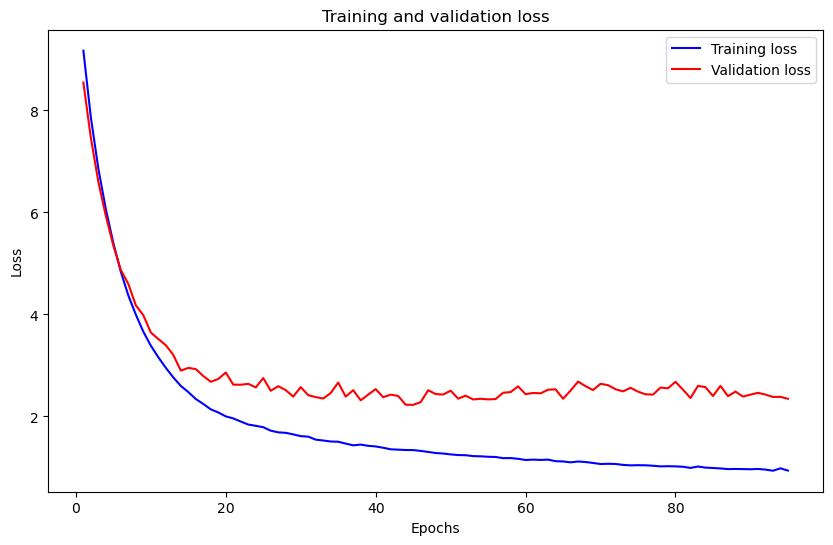

<Figure size 640x480 with 0 Axes>

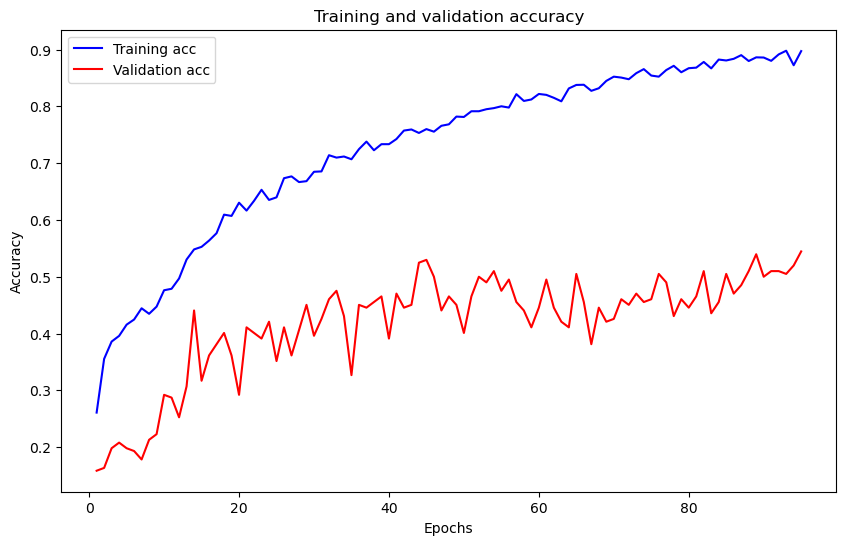

7/7 [==============================] - 0s 12ms/step - loss: 2.2281 - categorical_accuracy: 0.5297
Epoch 1/1000
25/25 [==============================] - 2s 66ms/step - loss: 9.1948 - categorical_accuracy: 0.2481 - val_loss: 8.5371 - val_categorical_accuracy: 0.1931
Epoch 2/1000
25/25 [==============================] - 1s 59ms/step - loss: 7.9139 - categorical_accuracy: 0.3291 - val_loss: 7.4650 - val_categorical_accuracy: 0.1931
Epoch 3/1000
25/25 [==============================] - 1s 59ms/step - loss: 6.9047 - categorical_accuracy: 0.3657 - val_loss: 6.7694 - val_categorical_accuracy: 0.1881
Epoch 4/1000
25/25 [==============================] - 1s 59ms/step - loss: 6.0942 - categorical_accuracy: 0.3868 - val_loss: 5.9805 - val_categorical_accuracy: 0.1634
Epoch 5/1000
25/25 [==============================] - 2s 69ms/step - loss: 5.4333 - categorical_accuracy: 0.3874 - val_loss: 5.4045 - val_categorical_accuracy: 0.1485
Epoch 6/1000
25/25 [==============================] - 1s 59ms/step 

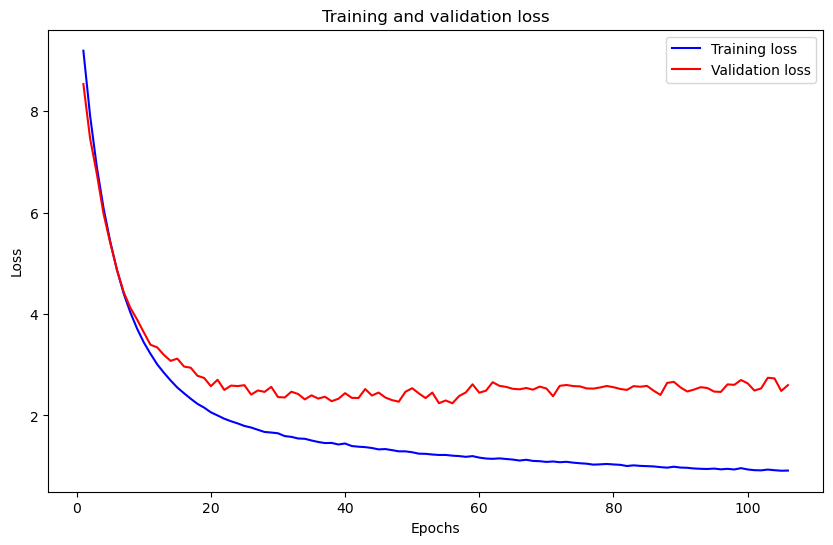

<Figure size 640x480 with 0 Axes>

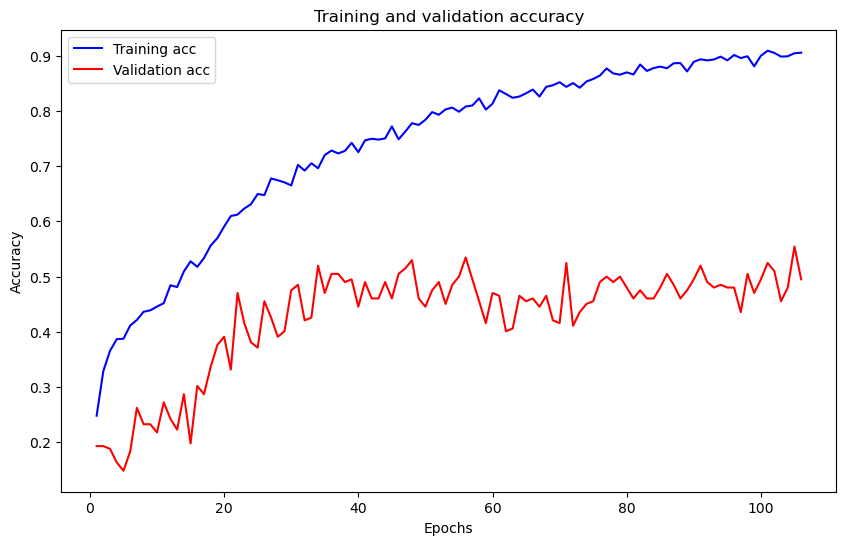

7/7 [==============================] - 0s 7ms/step - loss: 2.2398 - categorical_accuracy: 0.5347
Epoch 1/1000
25/25 [==============================] - 2s 66ms/step - loss: 9.1690 - categorical_accuracy: 0.2601 - val_loss: 8.4923 - val_categorical_accuracy: 0.1337
Epoch 2/1000
25/25 [==============================] - 1s 59ms/step - loss: 7.8325 - categorical_accuracy: 0.3557 - val_loss: 7.4040 - val_categorical_accuracy: 0.1832
Epoch 3/1000
25/25 [==============================] - 1s 59ms/step - loss: 6.8190 - categorical_accuracy: 0.3832 - val_loss: 6.5122 - val_categorical_accuracy: 0.2178
Epoch 4/1000
25/25 [==============================] - 1s 59ms/step - loss: 6.0152 - categorical_accuracy: 0.3858 - val_loss: 5.9254 - val_categorical_accuracy: 0.1584
Epoch 5/1000
25/25 [==============================] - 1s 59ms/step - loss: 5.3500 - categorical_accuracy: 0.4033 - val_loss: 5.2747 - val_categorical_accuracy: 0.1782
Epoch 6/1000
25/25 [==============================] - 2s 66ms/step -

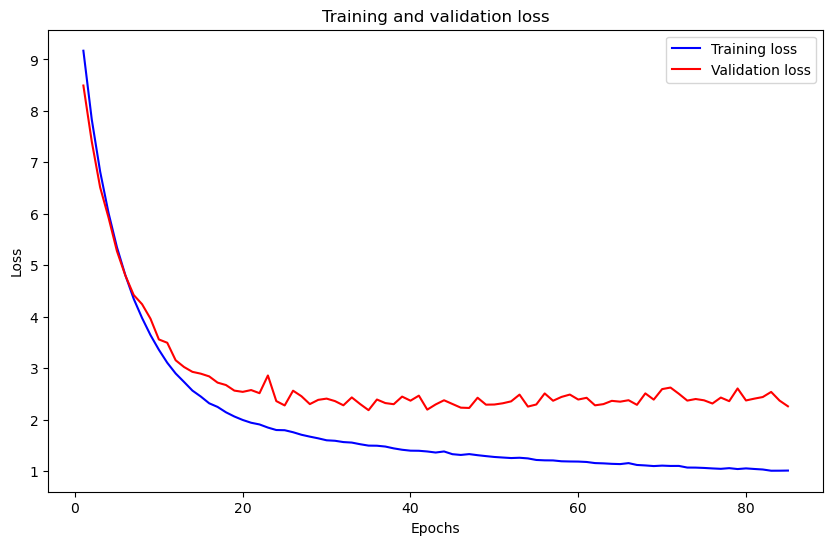

<Figure size 640x480 with 0 Axes>

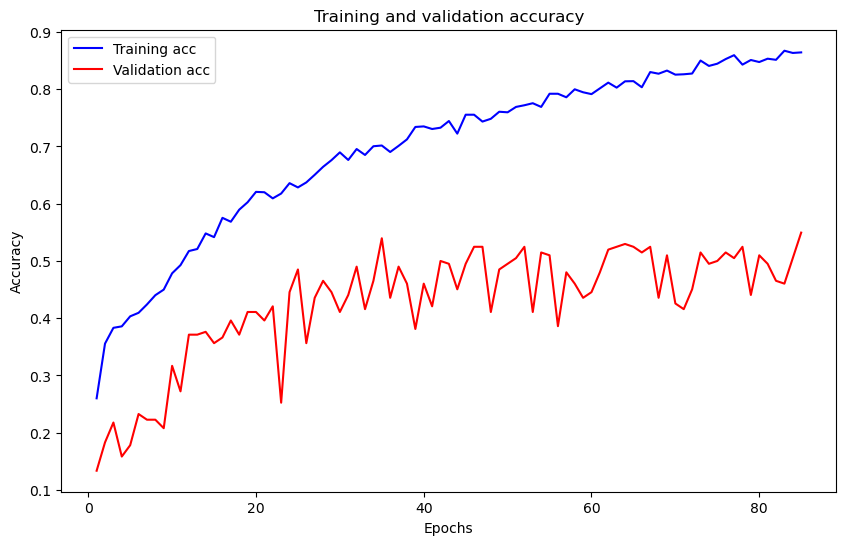

7/7 [==============================] - 0s 7ms/step - loss: 2.1826 - categorical_accuracy: 0.5396
Validation loss: 2.2168 ± 0.0247
Validation accuracy: 0.5347 ± 0.0040


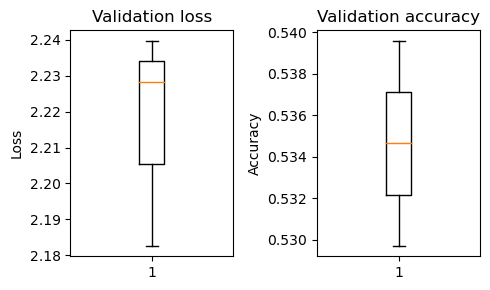

In [113]:
val_loss, val_acc, clf = evaluate_val(X_train_final,y_train_final,validation_data, lr=0.0001, ks=20, l2=0.01, n_runs=3, multihead=multihead, epochs=1000, batch_size=128)

14/14 [==============================] - 0s 9ms/step
                   precision  recall  f1-score  support
AMCVn                   0.11    0.14      0.12       14
dwarf_nova_SU_UMa       0.78    0.64      0.70      191
dwarf_nova_U_Gem        0.44    0.48      0.46       31
dwarf_nova_Z_Cam        0.38    0.35      0.36       55
int_polar               0.07    0.11      0.09       19
nova                    0.22    0.71      0.33        7
nova_like               0.37    0.27      0.31       52
nova_like_VY_Scl        0.25    0.57      0.35       30
polar                   0.39    0.21      0.27       33
accuracy                0.47    0.47      0.47        0
macro avg               0.33    0.39      0.33      432
weighted avg            0.53    0.47      0.49      432


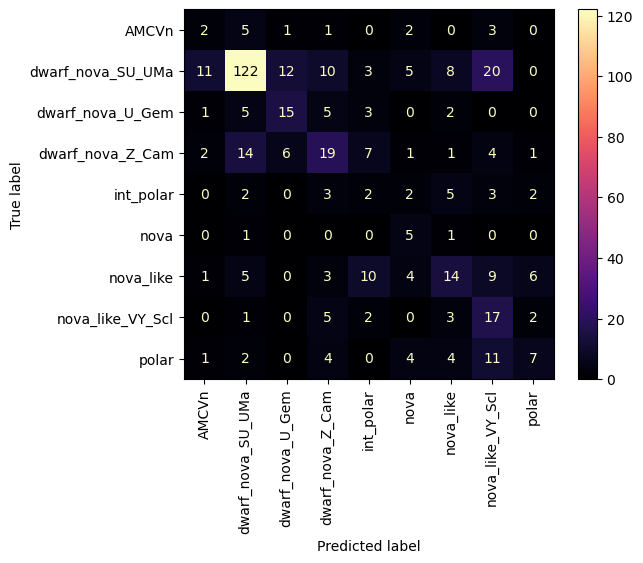

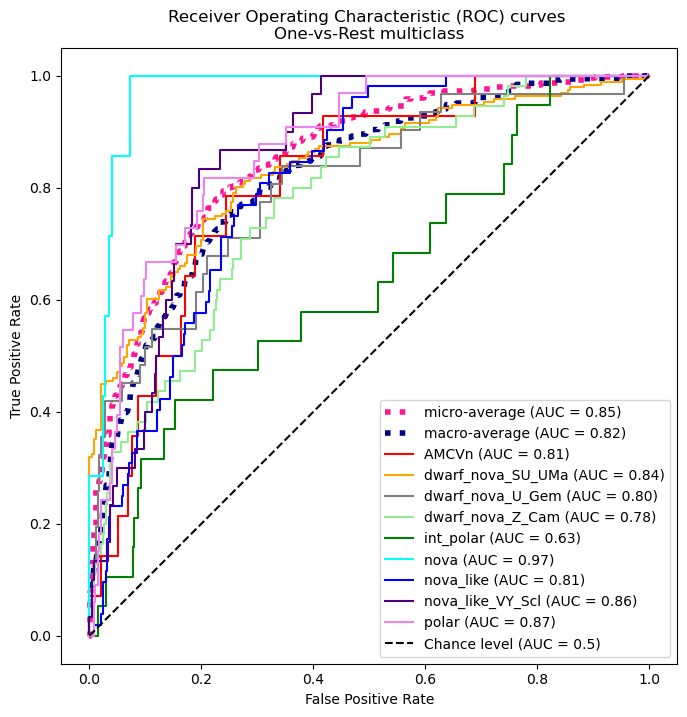

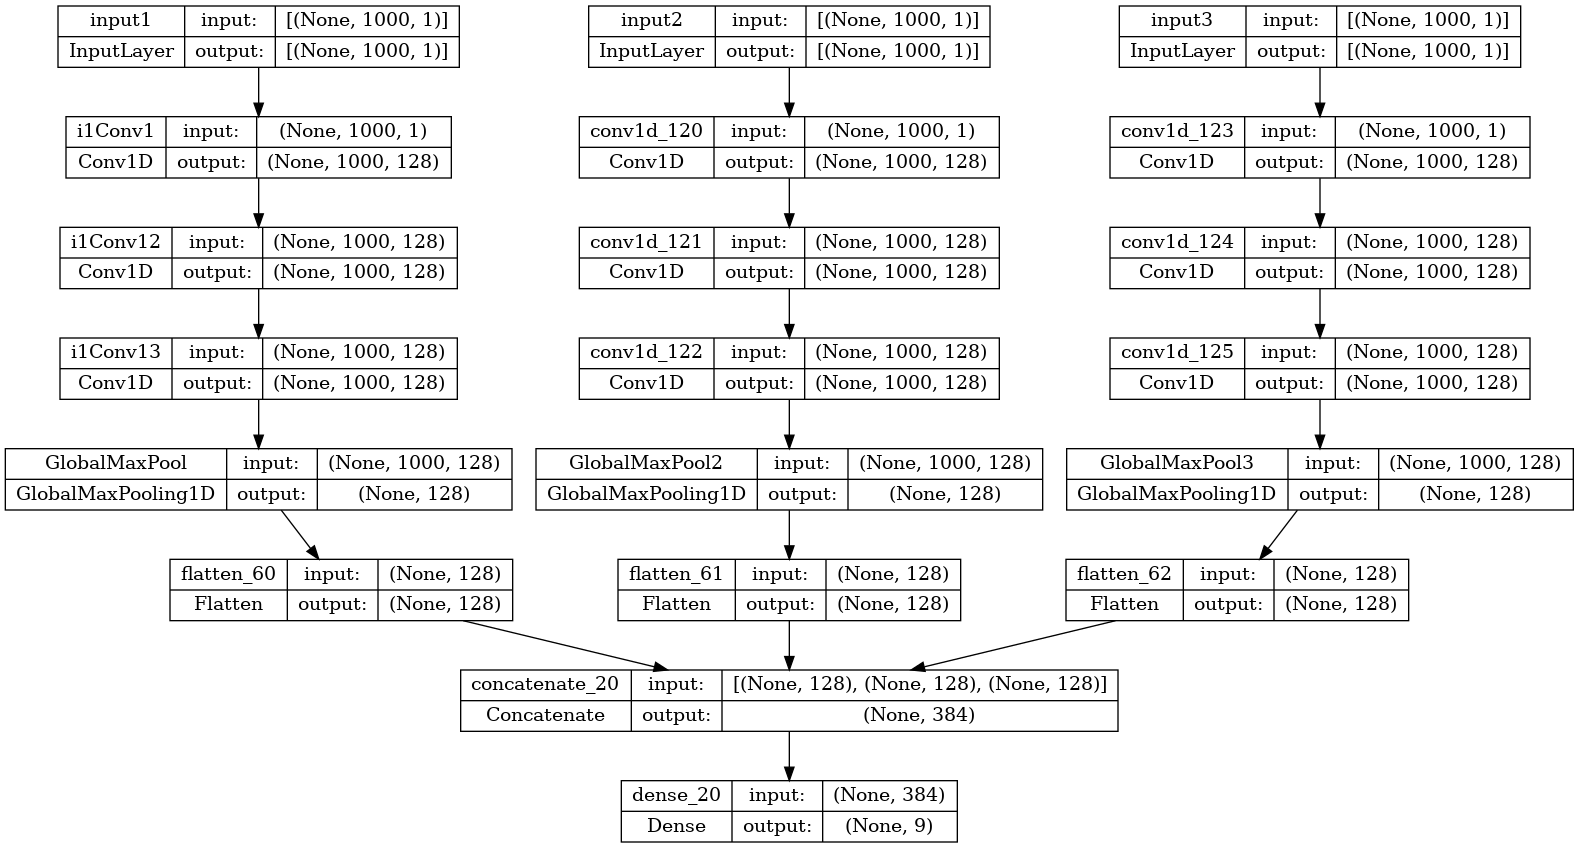

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test=''
description = 'mh_g&r&clr_int_bf_1000_ks20'
# description = ''
# Store best parameters and best model in variables.
# best_model = load_model(f'../results/model/NNCheckpoint1.hdf5')
# best_model = load_model(f'../results/model/NNCheckpoint{0}.hdf5')
best_model = clf

# # Get the labels as names
# y_names = dataset[label_scheme].to_numpy()
# # Encode the labels
# enc = LabelEncoder().fit(y_names)
# y_num = enc.transform(y_names)
# # One hot encode the labels
# y = to_categorical(y_num)

# Collect unique class labels in order of y_test.
y_test_labels = np.argmax(y_test, axis=1)
class_labels = enc.inverse_transform(np.unique(y_test_labels))

# Make predictions and gather probabilities for applying model to test set.

y_pred_prob = best_model.predict(test_data[0])
y_pred = np.argmax(y_pred_prob, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma')
disp.figure_.savefig(f'../results/1dcnn/cm/cm_{description}{test}.pdf', format='pdf', bbox_inches='tight')


# Print and save the classification report
pd.options.display.max_rows=None
cr = classification_report(y_test_labels, y_pred, target_names=enc.inverse_transform(np.unique(y_train_labels)), output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
cr_df.to_csv(f'../results/1dcnn/cr/cr_{description}{test}.csv')
print(cr_df)

plot_roc(y_train_labels, y_test_labels, y_pred_prob, enc, path=f'../results/1dcnn/roc_curve/{description}{test}.pdf')

clf.save(f'../results/1dcnn/model/{description}{test}.h5')

keras.utils.plot_model(clf, show_shapes=True, show_layer_names=True)